Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best Params: {'subsample': 0.8, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}

📊 Final Test Metrics (No Leakage)
MAE           = 38.69
RMSE          = 59.67
R²            = 0.9266
Adjusted R²   = 0.9259

✅ Final model (no leakage) + features saved. Metrics recorded in results/final_metrics.md


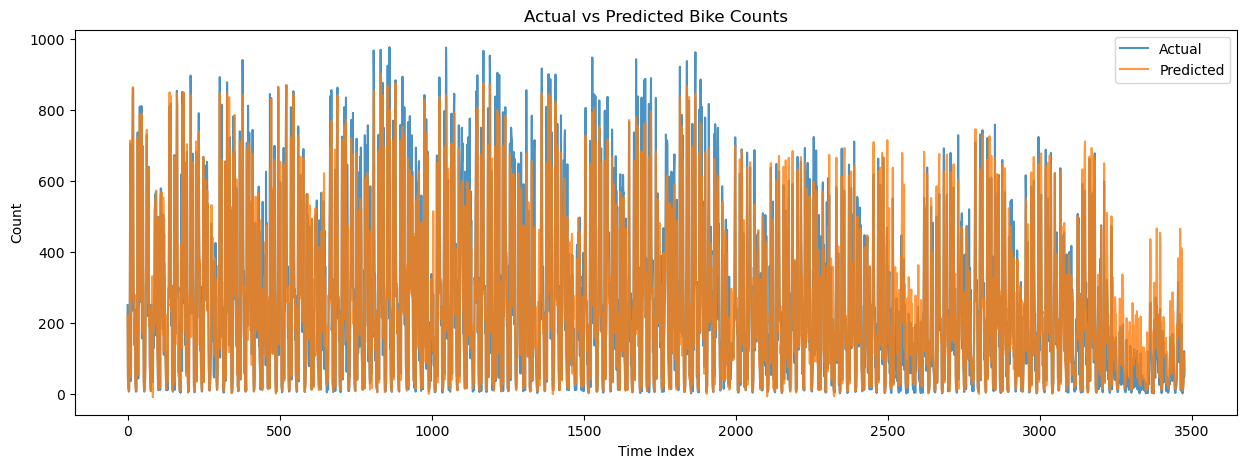

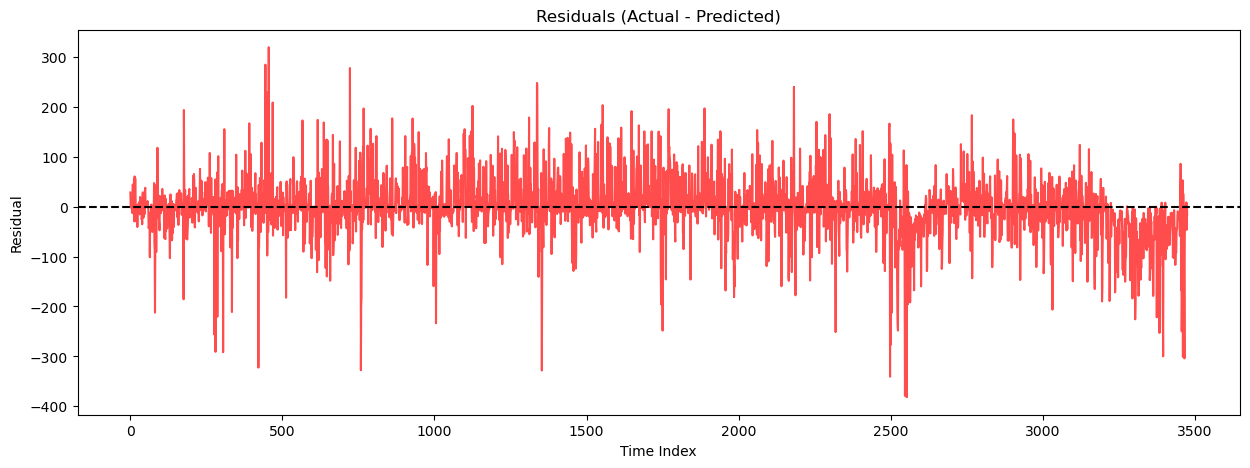

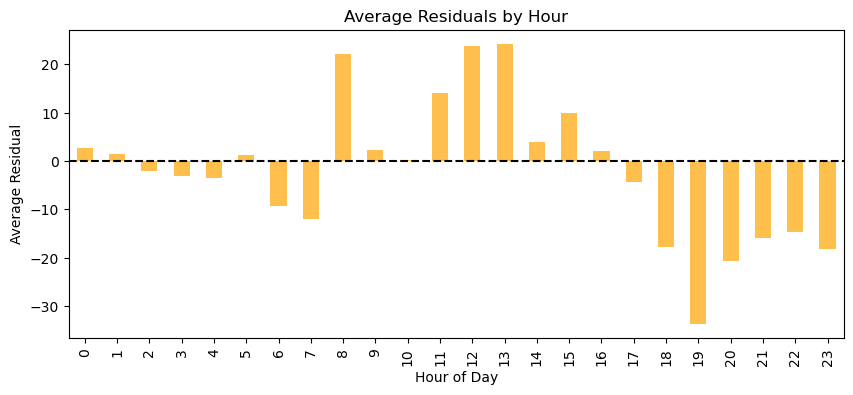

In [1]:
import pandas as pd
import numpy as np
import json
import joblib
import os
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ---------------------------
# 1️⃣ Load Dataset
# ---------------------------
df = pd.read_csv("data/hour.csv", parse_dates=["dteday"])
df = df.sort_values("dteday")

# ---------------------------
# 2️⃣ Feature Engineering
# ---------------------------

# Time-based features
df['hour'] = df['hr']
df['day_of_week'] = df['dteday'].dt.dayofweek
df['month'] = df['dteday'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['season'] = df['season'].astype(str)
df['weathersit'] = df['weathersit'].astype(str)

# ✅ Cyclical encoding for hour, day_of_week, month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# ✅ Lag & rolling features
df['cnt_lag1'] = df['cnt'].shift(1).bfill()
df['cnt_lag24'] = df['cnt'].shift(24).bfill()
df['cnt_roll3'] = df['cnt'].shift(1).rolling(3).mean().bfill()
df['cnt_roll6'] = df['cnt'].shift(1).rolling(6).mean().bfill()
df['cnt_roll12'] = df['cnt'].shift(1).rolling(12).mean().bfill()

# ✅ Interaction features
df['hour_temp'] = df['hour'] * df['temp']
df['hour_humidity'] = df['hour'] * df['hum']
df['temp_humidity'] = df['temp'] * df['hum']

# Feature columns (remove leakage)
feature_cols = df.drop(columns=['cnt', 'dteday', 'casual', 'registered']).columns

# Create X and y
X = df[feature_cols].copy()  # copy to avoid warnings
y = df['cnt']

# Convert categorical columns safely
for col in ['season', 'weathersit']:
    X[col] = X[col].astype('category')

# Train-test split (last 20% as test)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# ---------------------------
# 3️⃣ Hyperparameter Tuning
# ---------------------------
param_grid = {
    "n_estimators": [500, 700, 1000],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2]
}

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
)

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=30,   # more iterations for better search
    cv=tscv,
    scoring="neg_mean_absolute_error",
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print("✅ Best Params:", search.best_params_)

# ---------------------------
# 4️⃣ Evaluate on Test Set
# ---------------------------
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Adjusted R²
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"\n📊 Final Test Metrics (No Leakage)")
print(f"MAE           = {mae:.2f}")
print(f"RMSE          = {rmse:.2f}")
print(f"R²            = {r2:.4f}")
print(f"Adjusted R²   = {adjusted_r2:.4f}")

# ---------------------------
# 5️⃣ Save Artifacts
# ---------------------------
os.makedirs("artifacts", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Save using XGBoost native format
# Save using XGBoost native JSON format
best_model.get_booster().save_model("artifacts/model.json")


# Optional: still save features list
import json
with open("artifacts/features.json", "w", encoding="utf-8") as f:
    json.dump({"features": list(feature_cols)}, f)

json.dump({"features": list(feature_cols)}, open("artifacts/features.json","w"))

with open("results/final_metrics.md", "w", encoding="utf-8") as f:
    f.write("# Final Model Test Metrics (No Leakage)\n")
    f.write(f"- MAE: {mae:.2f}\n")
    f.write(f"- RMSE: {rmse:.2f}\n")
    f.write(f"- R²: {r2:.4f}\n")
    f.write(f"- Adjusted R²: {adjusted_r2:.4f}\n")

print("\n✅ Final model (no leakage) + features saved. Metrics recorded in results/final_metrics.md")

# ---------------------------
# 6️⃣ Error Analysis & Visualization
# ---------------------------
# Actual vs Predicted
plt.figure(figsize=(15,5))
plt.plot(y_test.values, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title("Actual vs Predicted Bike Counts")
plt.xlabel("Time Index")
plt.ylabel("Count")
plt.legend()
plt.show()

# Residuals
residuals = y_test.values - y_pred
plt.figure(figsize=(15,5))
plt.plot(residuals, color='red', alpha=0.7)
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Time Index")
plt.ylabel("Residual")
plt.axhline(0, color='black', linestyle='--')
plt.show()

# Hourly Residual Analysis
X_test_plot = X_test.copy()
X_test_plot['residual'] = residuals
hourly_error = X_test_plot.groupby('hour')['residual'].mean()

plt.figure(figsize=(10,4))
hourly_error.plot(kind='bar', color='orange', alpha=0.7)
plt.title("Average Residuals by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Residual")
plt.axhline(0, color='black', linestyle='--')
plt.show()
